Goal : Create a sklearn data pipeline to take the data from my matlab struct, convert it to a pandas data frame, clean and scale/standardize it. Create a sklearn estimator using psytrack to be able to use randomized search to optimize the hyperparameters of the model. Maybe also use a recursive feature elimination (https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py) to determine the optimal attributes to fir the data.

In [43]:
def mat_struct_2_pd(folderpath, file):
    import pandas as pd
    import os
    from scipy.io import loadmat
    import numpy as np

    file_data = 'analyze_animal_'+file+'.mat'
    path = os.path.join(folderpath,file_data);
    mouse_mat = loadmat(path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    m = mouse_mat['animal']
    beh = pd.DataFrame((m.lick.T).astype(bool))
    beh.columns = ['RH', 'LH', 'RM', 'LM', 'NG']
    beh['LED'] = (m.LED).astype(bool)
    beh['Session'] = m.sessionNum
    beh['Stimulus'] = m.stimulus
    beh['Target'] = m.target 

    file_ttl = 'ttl_info_'+file+'.mat'
    ttl_path = os.path.join(folderpath, file_ttl)
    mouse_ttl = loadmat(ttl_path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    beh['Spout_1']= np.mean(mouse_ttl['trial_info'].lick[:,750:825,0],axis = 1)
    beh['Spout_2'] = np.mean(mouse_ttl['trial_info'].lick[:,750:825,1],axis = 1)
    
    file_ttl2 = 'ttl_choices_'+file+'.mat'
    ttl_path2 = os.path.join(folderpath, file_ttl2)
    mouse_ttl2 = loadmat(ttl_path2, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    c = mouse_ttl2['trial_info'].choice[:,:,750:2750]
    rx = []
    ch= []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))
    
        if r.size == 0 and m.rxnTime[a] > 0:
            rx.append(m.rxnTime[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])
    
    beh['latency'] = rx
    #beh['early'] = ch
    

    file_training = 'analyze_training_'+file+'.mat'
    training_path = os.path.join(folderpath, file_training)
    mouse_train = loadmat(training_path,struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    train = mouse_train['training']
    tdata = {'trials_opto': [train.trials_opto], 'trials_prof': [train.trials_proficient],
        'trials_expert': [train.trials_expert], 'days_opto': [train.days_opto],
        'days_prof':[train.days_proficient], 'days_expert': [train.days_expert]}
    
    t = pd.DataFrame(tdata)


    

    return beh, t


In [44]:
def clean_behavior_data(b):
    import numpy as np
    import pandas as pd

    #b2 = b.copy()
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['Session'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['Stimulus']/8)/2
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['Target'].astype(int);
    b2['Session'] = b['Session'];

   
    b2['Latency'] = b['latency']/2000;
    #b2['New_session']= ns;
   
    go = (b['RH'] | b['LM'] | b['RM'] | b['LH']).values
    
    b2 = b2.iloc[go,:]
    
    return b2

In [45]:
folderpath = r'/Users/rebeccakrall/Downloads';
#folderpath = r'C:\Users\natet\Desktop\Experimental_Data\Control\c_129'
animal = 'c_129';

b,t = mat_struct_2_pd(folderpath, animal)
b2 = clean_behavior_data(b)

In [46]:
import numpy as np

inputs = dict(stim = np.expand_dims(np.array(b2['Stimulus']), axis=1),
    LED = np.expand_dims(np.array(b2['Stimulus']).astype(int), axis=1),
    previous_correct =  np.expand_dims(np.array(b2['Previous_correct']).astype(int), axis=1),
    previous_choice =  np.expand_dims(np.array(b2['Previous_rightward']).astype(int), axis=1),
    latency = np.expand_dims (np.array(b2['Previous_rightward']).astype(int), axis=1)
)   

dat = dict(
        subject = animal,
        inputs = inputs,
        correct = np.array(b2['Correct']),
        answer = np.array(b2['Target']),
        y = np.array(b2['Rightward']),
        dayLength=np.array(b2.groupby(['Session']).size()),
    )

In [47]:
weights = {k: 1 for k in inputs}
weights['bias'] = 1

In [ ]:
import psytrack as psy



k = np.sum([weights[i] for i in weights.keys()])
hyper = {'sigInit': 2**4., 'sigma': [2**4.]*k, 'sigDay': 2**4.};
optList = ['sigma', 'sigDay'];

hyp, full_model, wMode, hess_info = psy.hyperOpt(dat, hyper, weights, optList, showOpt = 0); 

In [18]:
import pickle
with open('opto_205_latency.pickle', 'rb') as f:
    data = pickle.load(f)

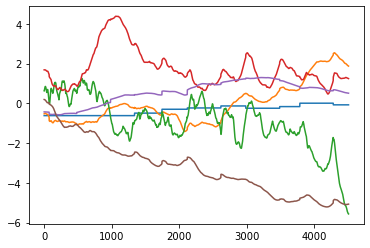

4505

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(data['wMode'].T)
plt.show()
len(data['wMode'][0])

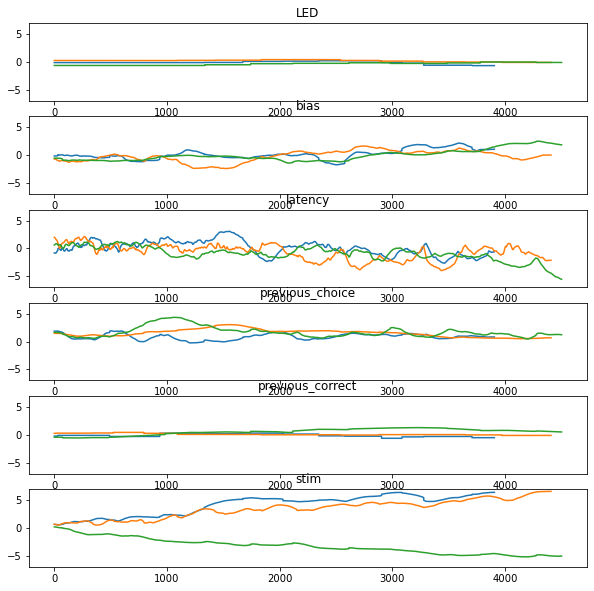

In [90]:
controls = ['c_129_latency.pickle', 'c_136_latency.pickle', 'c_137_latency.pickle']
cam = ['opto_200_latency.pickle', 'opto_96_latency.pickle', 'opto_97_latency.pickle']
et = ['opto_69_latency.pickle', 'opto_70_latency.pickle']
ct = ['opto_011_latency.pickle', 'opto_016_latency.pickle']
it = ['opto_203_latency.pickle', 'opto_204_latency.pickle', 'opto_205_latency.pickle', 'opto_206_latency.pickle']

groups = [controls, cam, et, ct, it]
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()

#for g in groups:
for fl in controls:
    with open(fl, 'rb') as f:
        data = pickle.load(f)
        for i in range(len(data['wMode'])):
             plt.subplot(len(data['wMode']),1, i+1)
             plt.plot(data['wMode'][i])
             plt.title(sorted(list(weights.keys()))[i])
             plt.ylim([-7, 7])




In [62]:
sorted(list(weights.keys()))[0]

'LED'

In [89]:
(data['wMode']).shape

(6, 5002)

In [70]:
test = np.array([])


In [79]:
a = data['wMode'][0];
b = np.array([1,3,4])